<a href="https://colab.research.google.com/github/msasikumar/DSC540/blob/master/utf_8''Sasi_DSC540_Assignment04_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  DSC540 Advanced Machine Learning
### Assignement 04
#### Sasikuamr Manickam
#### JUNE 06, 2020.


### Dataset

Continue to work with the breast cancer dataset from Assignment 1.

http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data


### Load data and process some basic cleanup

In [1]:
import numpy as np
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Read CSV file
cancer_df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

In [0]:
col=["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave_points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"]

In [0]:
cancer_df.columns=col

In [5]:
cancer_df.shape

(569, 32)

In [6]:
cancer_df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [0]:
#drop sample code number
cancer_df=cancer_df.drop(["id"],axis=1)

In [0]:
cancer_df["diagnosis"] = [1 if item == "M" else 0  for item in cancer_df["diagnosis"]]

In [0]:
from collections import OrderedDict
def run_models(df, target_feau, upper_order=5):

    '''
    Convenience function: 
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return (target_feau + ' '.join(['+ np.power(concave_points_worst,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

## Find Important features using RandomForestClassifiers (refer Assignment 2)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pymc3 as pm
from sklearn import metrics

X = cancer_df.drop(["diagnosis"],axis=1)  ## Data
y = cancer_df["diagnosis"]                ## Target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Import Random Forest Model

clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
    
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)


Accuracy: 0.9707602339181286


**Top 10 features based on RandomForestClassifier**

In [11]:
features = list(feature_imp.keys())
features_pr = features[0:10]
print (features_pr)

['concave_points_worst', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_mean', 'radius_mean', 'area_se', 'perimeter_mean', 'concavity_worst']


**Explore top 10 features**

In [12]:
features_11 = features_pr
features_11.append('diagnosis')
cancer_df11=cancer_df[features_11]
cancer_df11.head(3)

,concave_points_worst,concave_points_mean,radius_worst,perimeter_worst,area_worst,concavity_mean,radius_mean,area_se,perimeter_mean,concavity_worst,diagnosis
0,0.2654,0.14710,25.38,184.6,2019.0,0.3001,17.99,153.40,122.8,0.7119,1
1,0.1860,0.07017,24.99,158.8,1956.0,0.0869,20.57,74.08,132.9,0.2416,1
2,0.2430,0.12790,23.57,152.5,1709.0,0.1974,19.69,94.03,130.0,0.4504,1


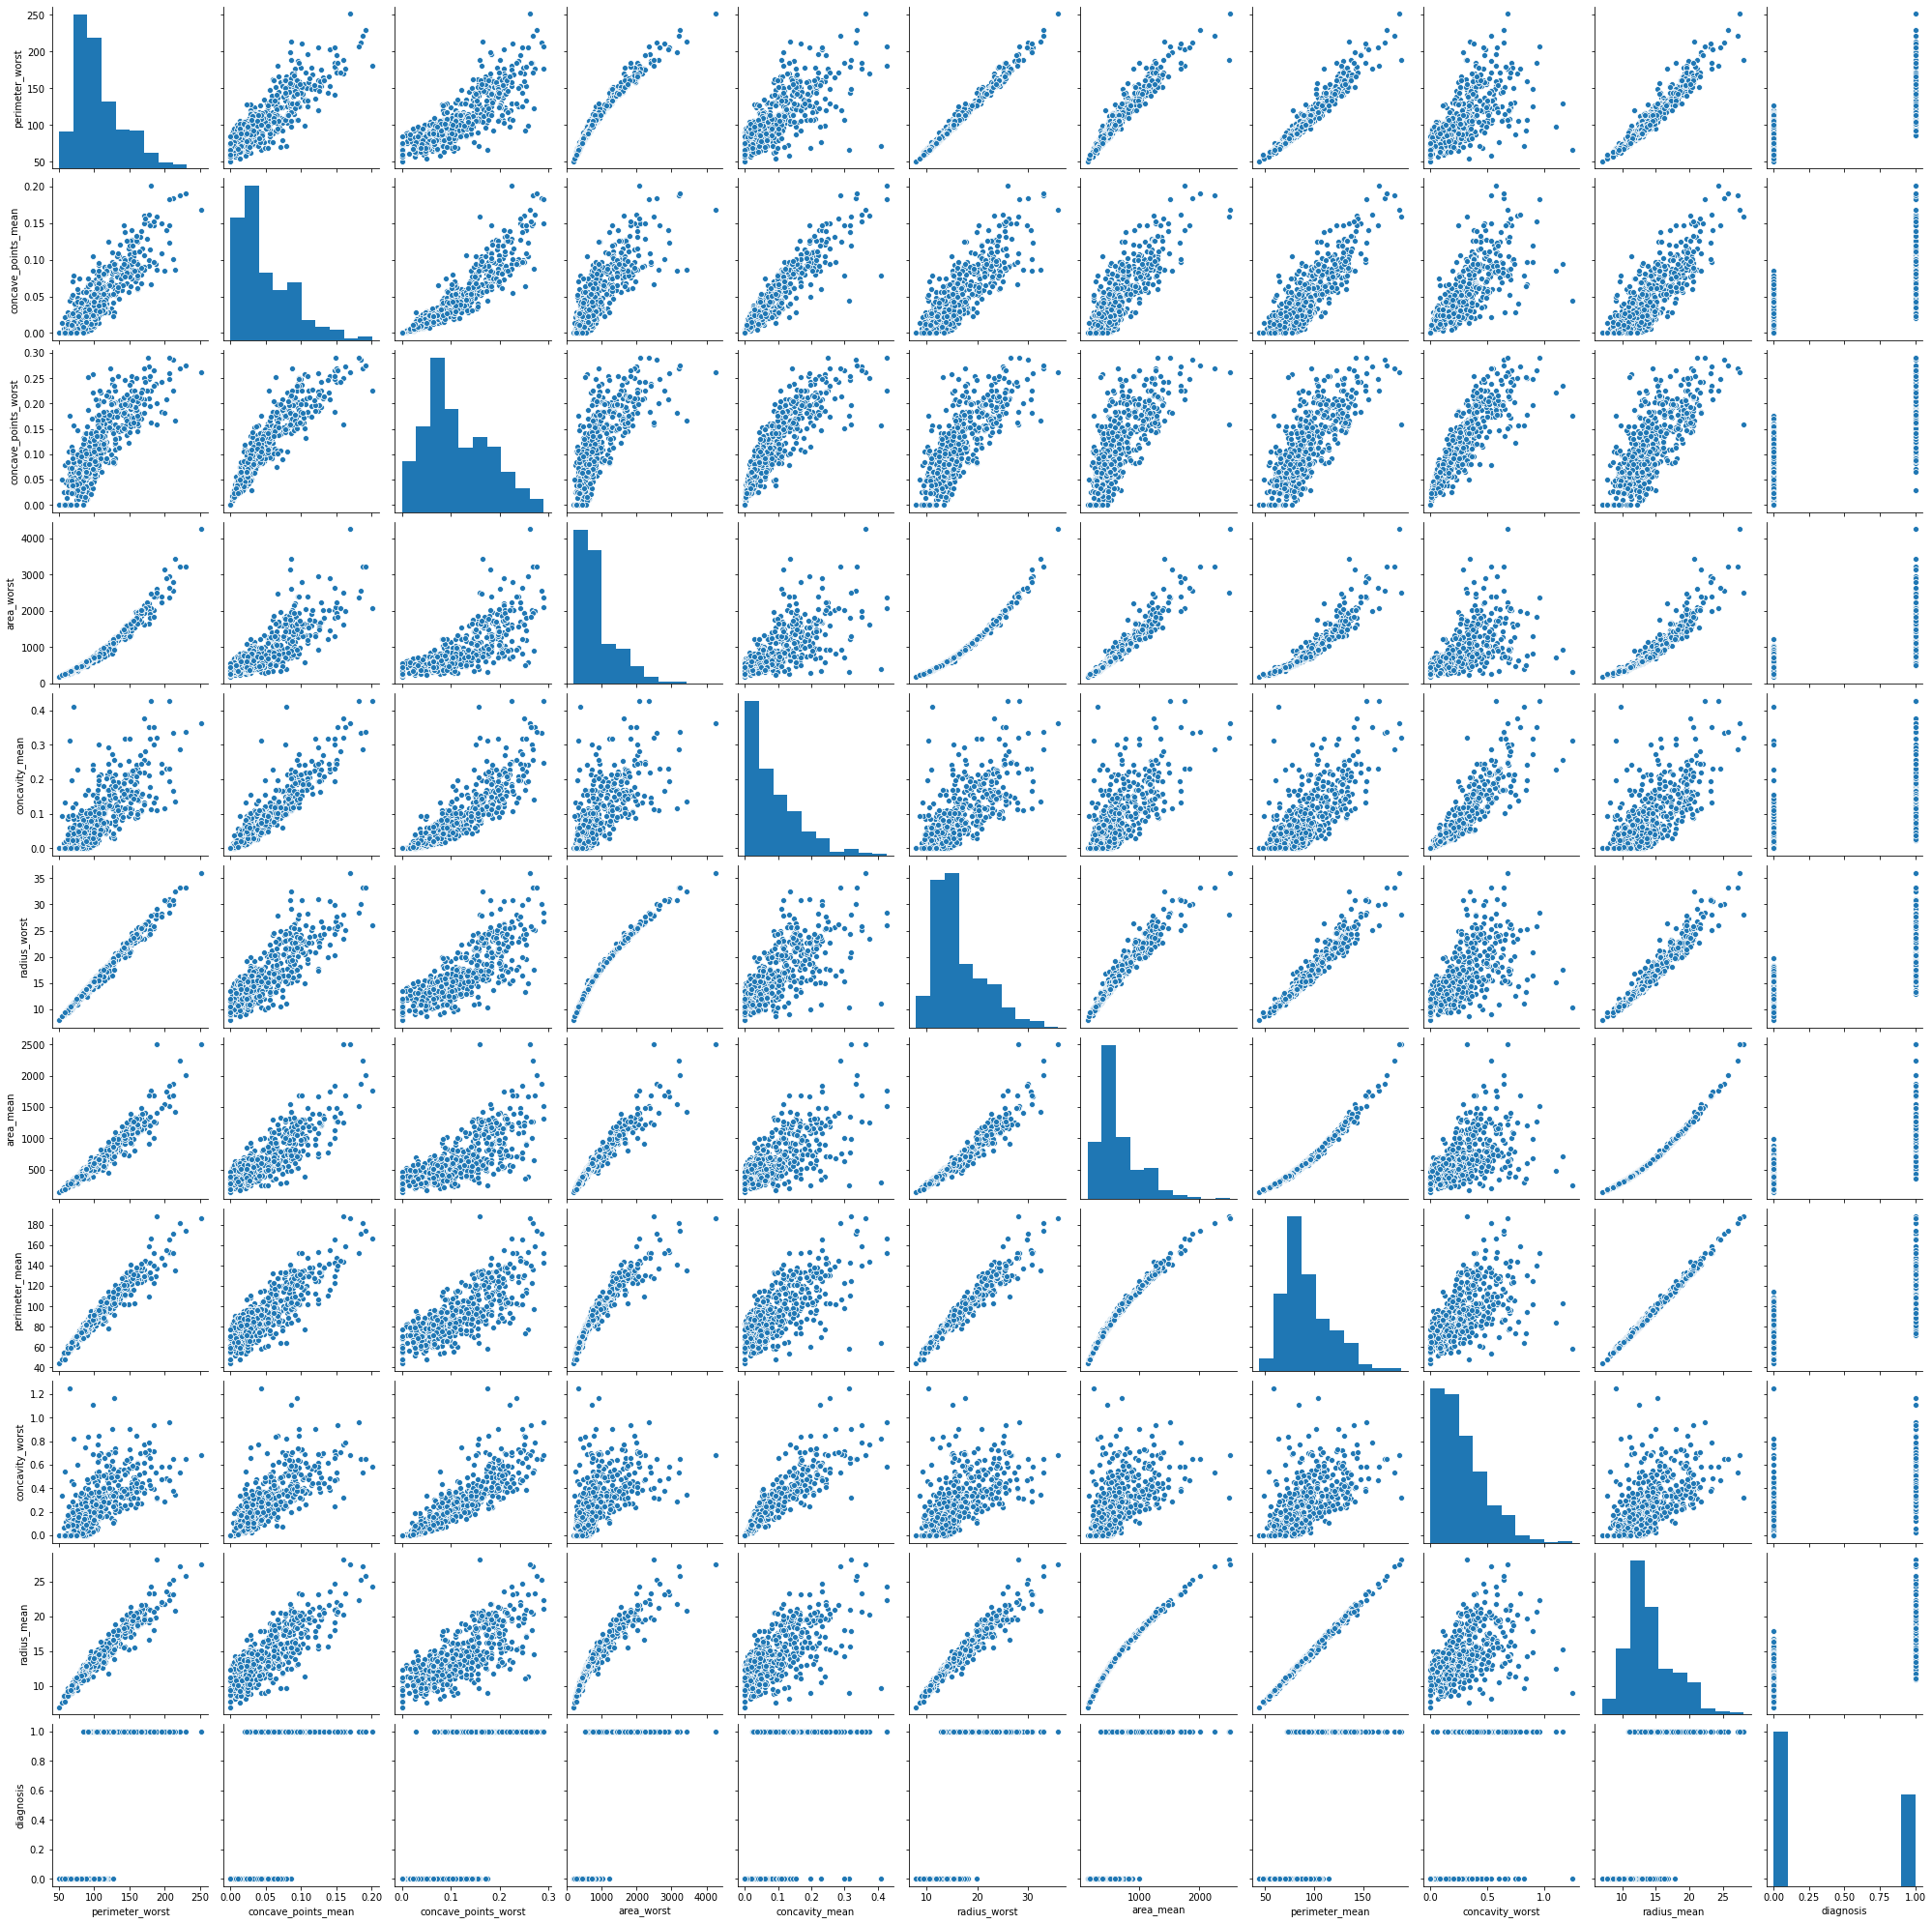

In [16]:
g = seaborn.pairplot(cancer_df11)

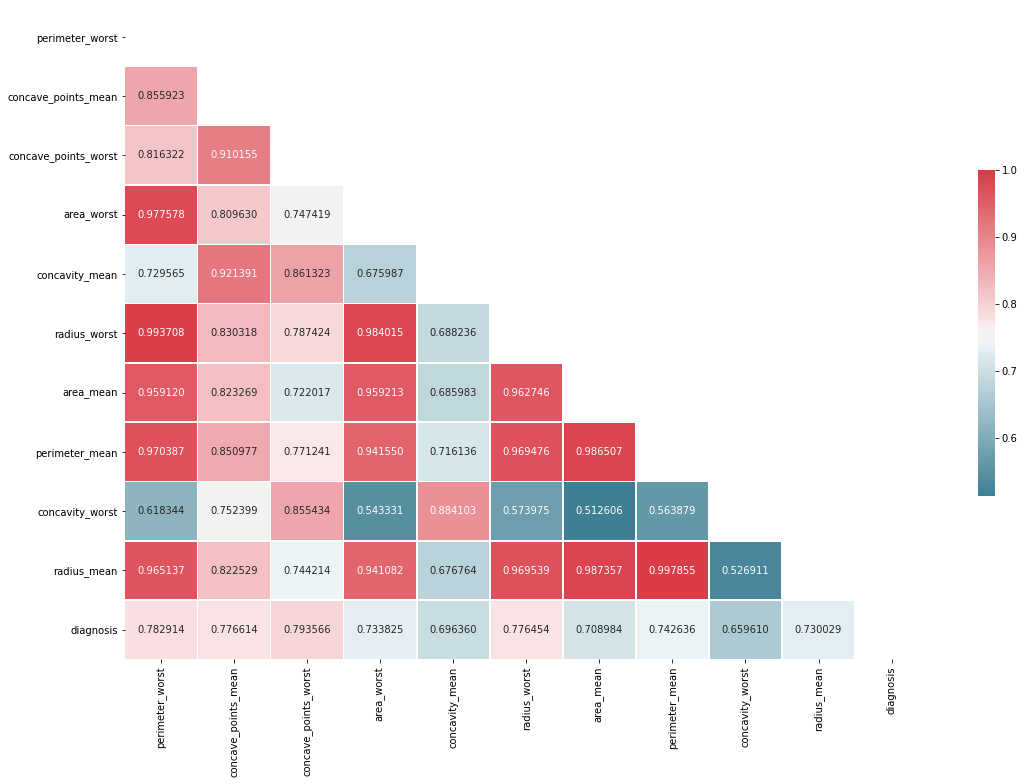

In [70]:
# Compute the correlation matrix
corr = cancer_df11.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
                linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt="f", ax=ax);

# Trace plot

In [0]:
target_feau= 'diagnosis ~ ' +  ' + '.join(features_pr)

In [19]:
target_feau

'diagnosis ~ perimeter_worst + concave_points_mean + concave_points_worst + area_worst + concavity_mean + radius_worst + area_mean + perimeter_mean + concavity_worst + radius_mean + diagnosis'

In [0]:
import pickle
from pathlib import Path
import pymc3 as pm
from sklearn.svm import SVC
#from sklearn.externals.joblib import parallel_backend

In [21]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula( target_feau,
                            cancer_df,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [diagnosis, radius_mean, concavity_worst, perimeter_mean, area_mean, radius_worst, concavity_mean, area_worst, concave_points_worst, concave_points_mean, perimeter_worst, Intercept]
Sampling chain 1, 219 divergences: 100%|██████████| 2000/2000 [04:19<00:00,  7.70it/s]
There were 847 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1066 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for so

In [0]:
import pickle
from pathlib import Path
output = open('traceq1.1.pkl', 'wb')
pickle.dump(trace, output)
output.close()

In [0]:
plot_traces(trace)

In [0]:
import sys
!{sys.executable} -m pip install --upgrade pymc3

**Credible intervals**

In [0]:
## List of credible intervals for top 10 features.
for fp in features_pr:
  b = trace[fp]
  lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
  print("{} \t: P({} < O.R. < {}) = 0.95".format(fp,np.exp(lb),np.exp(ub)))

Model selection

In [23]:
import collections
models_lin, traces_lin = run_models(cancer_df11, target_feau,3)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [diagnosis, radius_mean, concavity_worst, perimeter_mean, area_mean, radius_worst, concavity_mean, area_worst, concave_points_worst, concave_points_mean, perimeter_worst, Intercept]
Sampling chain 1, 705 divergences: 100%|██████████| 2000/2000 [01:14<00:00, 26.99it/s]
There were 553 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1259 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.power(concave_points_worst, 2), diagnosis, radius_mean, concavity_worst, perimeter_mean, area_mean, radius_worst, concavity_mean, area_worst, concave_points_worst, concave_points_mean, perimeter_worst, Intercept]
Sampling chain 1, 784 divergences: 100%|██████████| 2000/2000 [00:49<00:00, 40.21it/s]
There were 703 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1488 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [np.power(concave_points_worst, 3), np.power(concave_points_worst, 2), diagnosis, radius_mean, concavity_worst, perimeter_mean, area_mean, radius_worst, concavity_mean, area_worst, concave_points_worst, concave_points_mean, perimeter_worst, Intercept]
Sampling chain 1, 326 divergences: 100%|██████████| 2000/2000 [04:32<00:00,  7.34it/s]
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 683 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some 

In [0]:
#import dill
#dill.dump_session('assign4_notebook_env.db')

In [0]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})

dfwaic = pm.compare(model_trace_dict, ic='WAIC')


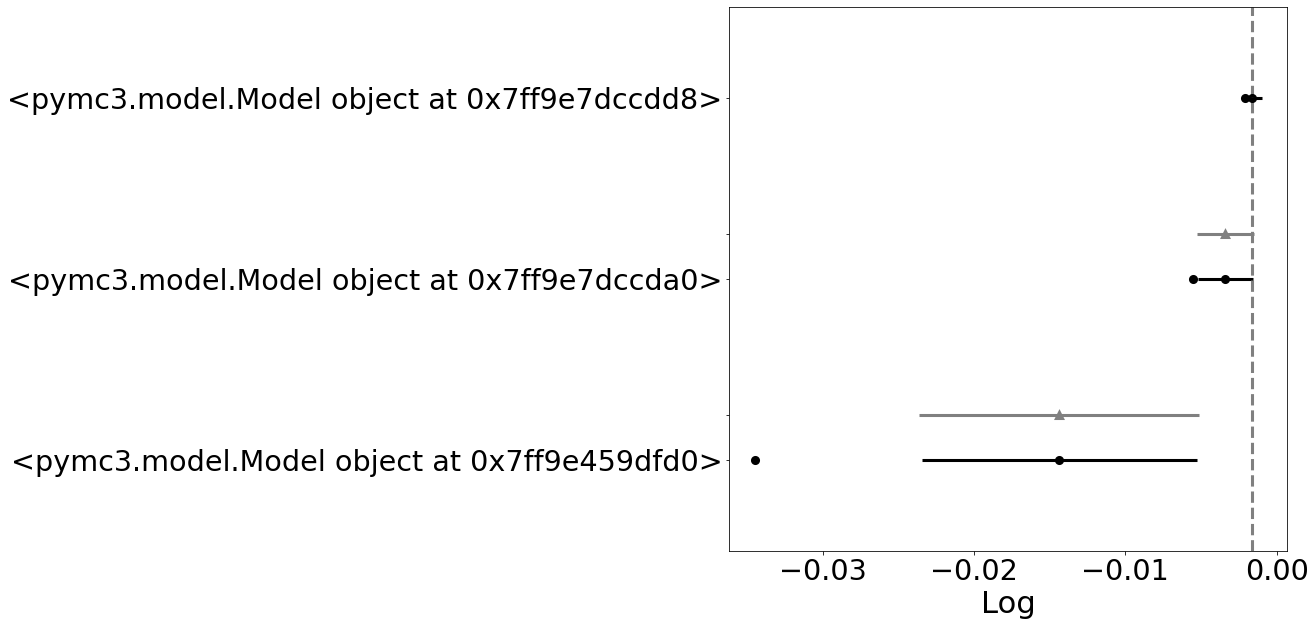

In [58]:
pm.compareplot (dfwaic,figsize=(10, 10));

In [0]:
import dill
dill.dump_session('assign4_notebook_env2.db')
# dill.load_session('assign4_notebook_env.db')

**Probabily of Breast cancer**

In [0]:
from google.colab import drive
drive.mount('/content/drive')